In [1]:
import pandas, seaborn, scipy, numpy, matplotlib, collections, sklearn, math, seaborn
import sklearn.linear_model

%matplotlib inline
from matplotlib import pyplot

# Constants
library_sizes = {
    'WGS': 3002000000,
    'WES': 50160183,
}
mhc_binding_threshold_affinity = 500

%matplotlib inline
%config InlineBackend.figure_format = 'png'

matplotlib.rc("savefig", dpi=800)
#matplotlib.rc("savefig", dpi=72)
matplotlib.rc('text', usetex=False)
#reload(c)

pandas.set_option('display.max_rows', 50)
pandas.set_option('display.max_columns', 50)

def print_full(x):
    pandas.set_option('display.max_rows', len(x))
    print(x)
    pandas.reset_option('display.max_rows')
    
def bootstrap(values, statistic=numpy.mean, samples=5000):
    values = pandas.Series(values).dropna()
    if len(values) <= 1:
        return (numpy.nan, numpy.nan)
    values = [statistic(sklearn.utils.resample(values)) for i in range(samples)]
    return (numpy.percentile(values, 5), numpy.percentile(values, 95))

def round_to_n(x, n):
    return round(x, -int(math.floor(math.log10(x))) + (n - 1)) 

def mean_with_errorbars(values, decimals=0):
    pattern = "%%0.%df" % decimals
    bars = bootstrap(values)
    if numpy.nan in bars:
        return pattern % numpy.mean(values)
    if decimals == 0:
        bars = (round_to_n(bars[0], 2), round_to_n(bars[1], 2)) 
    return (pattern + " (" + pattern + " - " + pattern + ")") % ((numpy.mean(values),) + bars)


/Users/tim/miniconda3/envs/py3k/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sources_with_signature_counts = pandas.read_csv(
    "../data/derived/sources.extended.with_signature_counts.csv",
    index_col="source_id")

In [3]:
sources_with_signature_counts.specific_treatment

source_id
AOCS-001-1-7              treatment naive
AOCS-004-1-5              treatment naive
AOCS-005-1-8              treatment naive
AOCS-034-1-0              treatment naive
AOCS-034-3-8        adjuvant chemotherapy
AOCS-055-1-7              treatment naive
AOCS-056-1-X              treatment naive
AOCS-057-1-2              treatment naive
AOCS-058-1-5              treatment naive
AOCS-059-1-8              treatment naive
AOCS-060-1-5              treatment naive
AOCS-061-1-8              treatment naive
AOCS-063-1-3              treatment naive
AOCS-064-1-6              treatment naive
AOCS-064-3-3        adjuvant chemotherapy
AOCS-065-1-9              treatment naive
AOCS-065-3-6        adjuvant chemotherapy
AOCS-075-1-0              treatment naive
AOCS-076-1-3              treatment naive
AOCS-077-1-6     neoadjuvant chemotherapy
AOCS-078-1-9              treatment naive
AOCS-079-1-1              treatment naive
AOCS-080-1-9              treatment naive
AOCS-081-1-1            

mutations treatment naive 104.752552144 [  2.05446356  12.61052693  33.71700952  18.8795367   30.64576027
   0.77760967   6.06764549]
mutations adjuvant chemotherapy 105.491701586 [  6.43771735   5.39202824  42.51928223  16.91727575  27.25283787
   1.24078641   5.73177373]
mutations neoadjuvant chemotherapy 105.584109686 [  0.18471977  18.56607421  26.67509998  21.66211812  29.77794261
   0.67515182   8.04300318]
neoantigens treatment naive 98.9054987387 [  1.51034902  16.18861215  27.97398083  13.64421122  24.0532586
   0.94643646  14.58865045]
neoantigens adjuvant chemotherapy 99.8340140265 [  4.97286512   7.71163496  36.79323078  13.40990086  23.08805805
   1.65550791  12.20281634]
neoantigens neoadjuvant chemotherapy 98.2694403056 [  0.07412644  19.633193    17.7073732   13.48784104  20.89028252
   0.52665694  25.94996715]
expressed neoantigens treatment naive 98.6658954564 [  1.66801335  17.60980139  33.13960966  15.39847824  29.04109954
   0.75656976   1.05232351]
expressed neoan

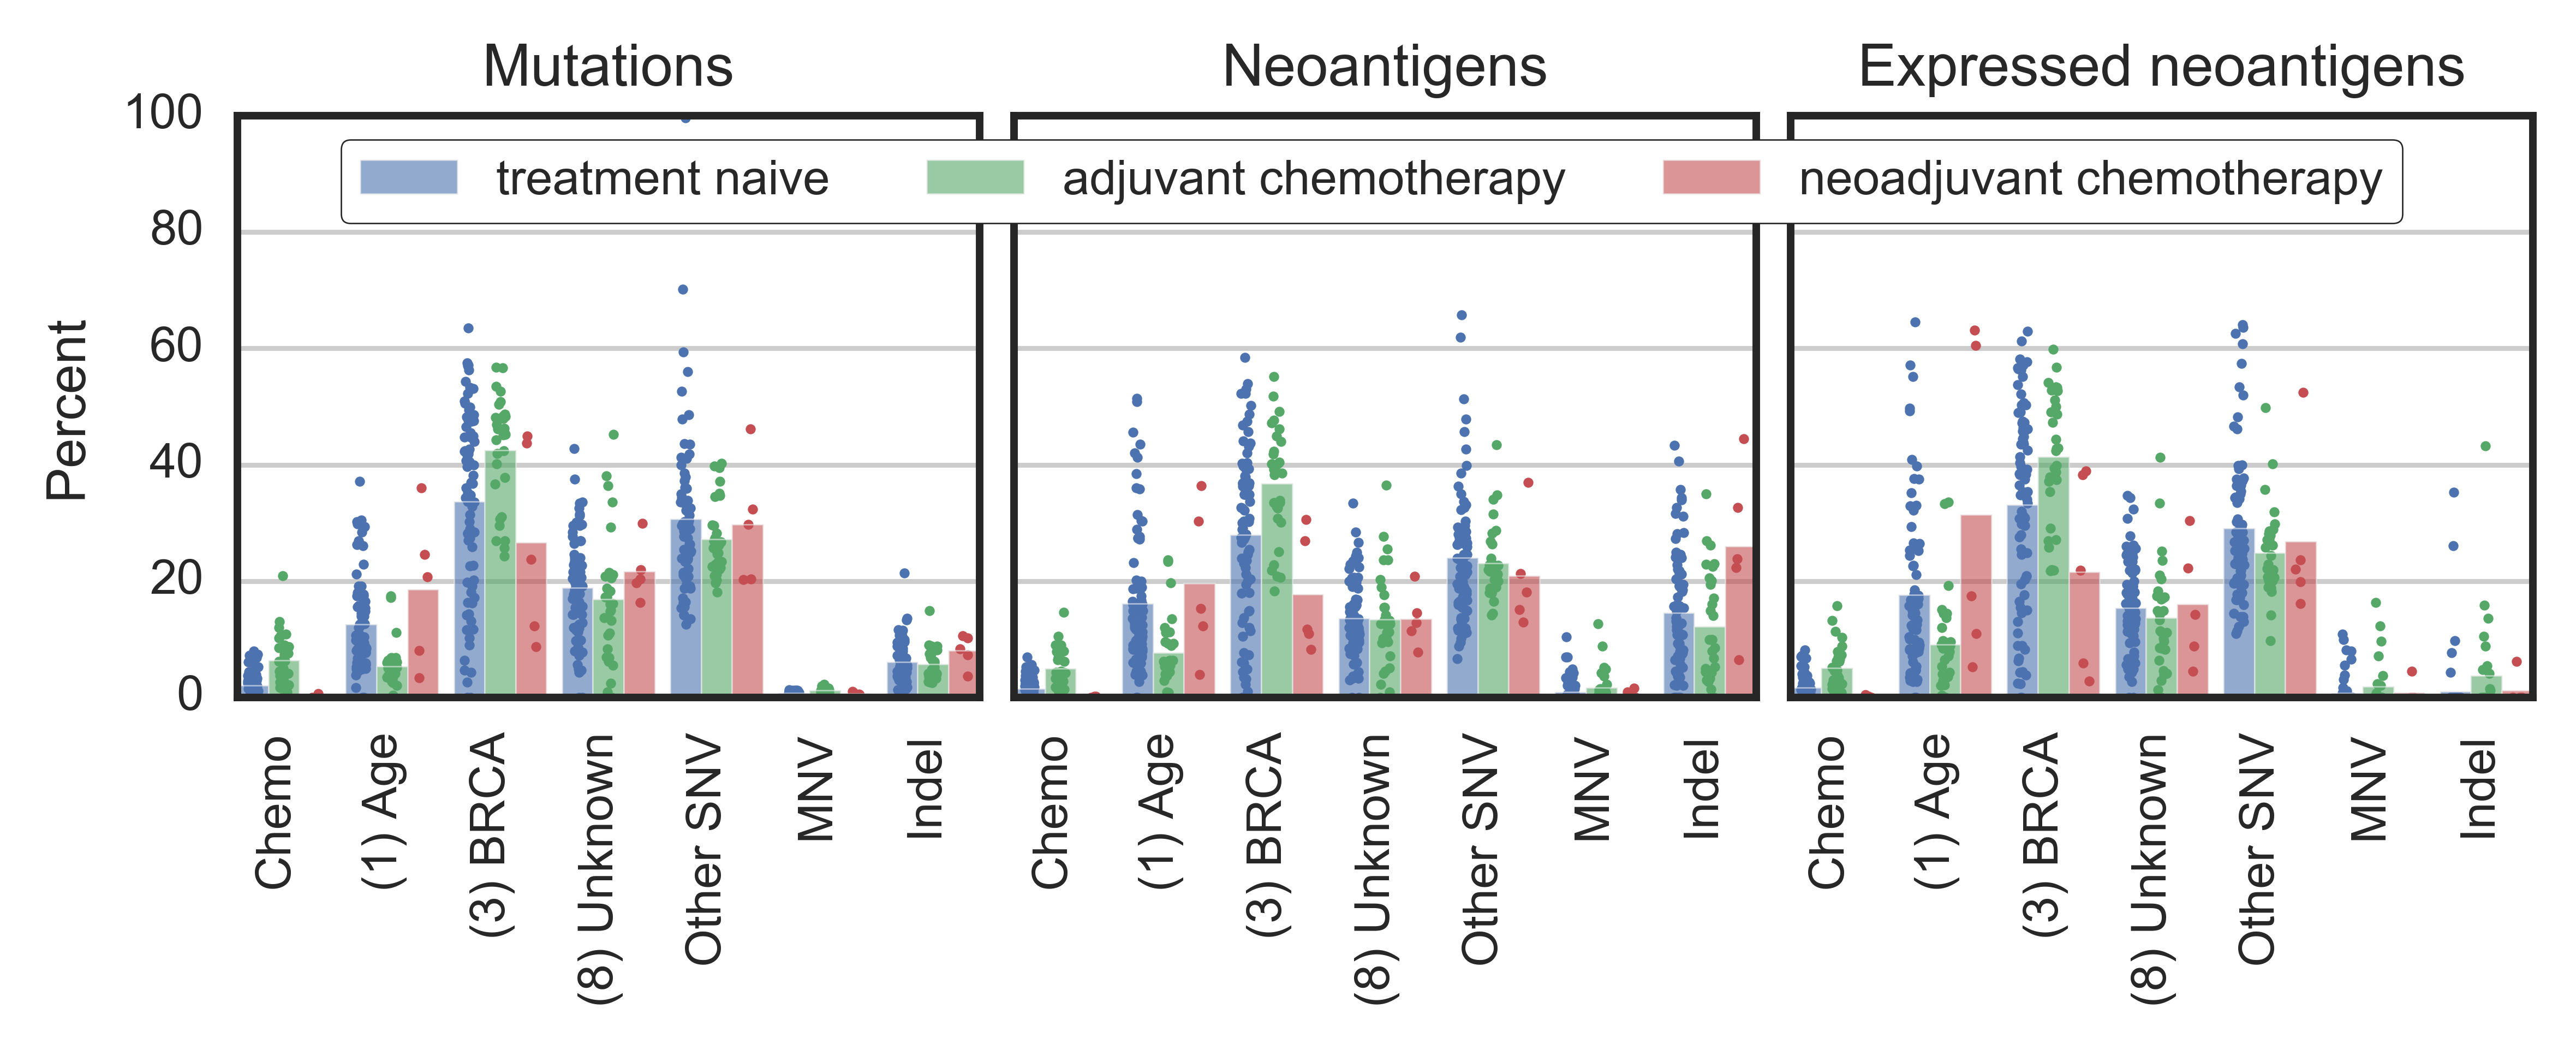

In [9]:
for key in ['mutations', 'neoantigens', 'expressed neoantigens']:
    sources_with_signature_counts["chemo %s" % key] = (
        sources_with_signature_counts["Cisplatin Gallus gallus %s" % key]
        + sources_with_signature_counts['Cyclophosphamide Gallus gallus %s' % key]
        + sources_with_signature_counts['Cisplatin C Elegans %s' % key]

        #+ sources_with_signature_counts['Cisplatin C Elegans fcd 2 %s' % key]
        #+ sources_with_signature_counts['Cisplatin C Elegans polq 1 %s' % key]
        #+ sources_with_signature_counts['Cisplatin C Elegans xpf 1 %s' % key]
    )

display_signatures = [
    "chemo",
    "Signature 1",
    "Signature 3",
    "Signature 8",
    "other snv",
  #  "residual",
    "mnv",
    "indel",
]

import itertools

def cleanup_name(col):
    return (
        col
        .replace("mnv", "MNV")
        .replace("mutations", "")
        .replace("neoantigens", "")
        .replace("other snv", "Other SNV")
        .replace("indel", "Indel")
        .replace("residual", "Unclassified")
        .replace("chemo", "Chemo")
        .replace("Signature 1", "(1) Age")
        .replace("Signature 3", "(3) BRCA")
        .replace("Signature 8", "(8) Unknown")
        .replace("expressed", "")
        .strip())

def jiggle(arr):
    return arr + (numpy.random.rand(len(arr)) - 0.5) / 3.0

def plot_mutations_or_neoantigens(which):
    palette = itertools.cycle(seaborn.color_palette())
    cols = [x + " " + which for x in display_signatures]
    #masks = [
    #    ("pre-treatment", (~ sources_with_signature_counts.treated)),
    #    ("post-treatment", (sources_with_signature_counts.treated)),
    #]
    masks = [
        (name, sources_with_signature_counts.specific_treatment == name)
        for name in sources_with_signature_counts.specific_treatment.unique()
    ]
    offset = 0
    for (label, mask) in masks:
        label_sources = sources_with_signature_counts.ix[mask]
        xs = numpy.arange(len(cols)) * 3.5 + offset
        full_ys = numpy.array([label_sources[col] for col in cols]) * 100.0
        ys = numpy.mean(full_ys, axis=1)
        print(which, label, ys.sum(), ys)
        ranges = numpy.array([bootstrap(label_sources[col]) for col in cols]).T * 100.0
        error_low = ys - ranges[0]
        error_hi = ranges[1] - ys
        color = next(palette)
        pyplot.bar(
            xs,
            ys,
            #yerr=numpy.array([error_low, error_hi]),
            ecolor="grey",
            capsize=0,
            label=label,
            color=color,
            alpha=0.6,
            width=1.0)
        pyplot.scatter(
            jiggle(numpy.array([xs + 0.5 for _ in range(full_ys.shape[1])]).flatten()),
            full_ys.T.flatten(),
            color=color,
            s=2.0)
        offset += 1
        
    pyplot.xticks(xs - .75, [cleanup_name(c) for c in cols], rotation=90)
    pyplot.ylim(ymin=0, ymax=100)
    pyplot.xlim(xmin=0, xmax=xs.max() + 1.0)


pyplot.figure(figsize=(6,2.5))
seaborn.set_context("paper")
seaborn.set_style('white')

pyplot.subplot(131)
plot_mutations_or_neoantigens("mutations")
pyplot.title("Mutations")
pyplot.ylabel("Percent")
pyplot.gca().yaxis.grid(True)

#for label in pyplot.gca().yaxis.get_ticklabels()[1::2]:
#    label.set_visible(False)
    
pyplot.subplot(132, sharey=pyplot.gca())
plot_mutations_or_neoantigens("neoantigens")
pyplot.title("Neoantigens")
pyplot.gca().yaxis.grid(True)
pyplot.gca().label_outer()

pyplot.subplot(133, sharey=pyplot.gca())
plot_mutations_or_neoantigens("expressed neoantigens")
pyplot.title("Expressed neoantigens")
pyplot.gca().yaxis.grid(True)
pyplot.gca().label_outer()

pyplot.subplot(131)
pyplot.gca().set_zorder(10)
legend = pyplot.legend(ncol=3, fancybox=True, frameon=True, fontsize='small', framealpha=1, bbox_to_anchor=(2.95, 1.0))
legend.get_frame().set_facecolor('white')
legend.set_zorder(200)

pyplot.tight_layout(w_pad=0.5)


pyplot.savefig("../figures/sources_of_mutations_and_neoantigens.pdf",
               bbox_extra_artists=(legend,),
               bbox_inches='tight')


In [ ]:
sources_with_signature_counts["classic mutations"] = ((
    sources_with_signature_counts["Signature 1 mutations"] +
    sources_with_signature_counts["Signature 3 mutations"] + 
    sources_with_signature_counts["Signature 8 mutations"]))
sources_with_signature_counts["classic neoantigens"] = ((
    sources_with_signature_counts["Signature 1 neoantigens"] +
    sources_with_signature_counts["Signature 3 neoantigens"] + 
    sources_with_signature_counts["Signature 8 neoantigens"]))
sources_with_signature_counts["classic expressed neoantigens"] = ((
    sources_with_signature_counts["Signature 1 expressed neoantigens"] +
    sources_with_signature_counts["Signature 3 expressed neoantigens"] + 
    sources_with_signature_counts["Signature 8 expressed neoantigens"]))

In [ ]:
scipy.stats.mannwhitneyu(
    sources_with_signature_counts[sources_with_signature_counts.specific_treatment ==
    "treatment_naive"]["classic neoantigens"],
    sources_with_signature_counts[sources_with_signature_counts.specific_treatment ==
    "neoadjuvant_chemotherapy"]["classic neoantigens"])
        

In [ ]:
sources_with_signature_counts.groupby("specific_treatment")["classic mutations"].apply(
    lambda x: mean_with_errorbars(x, decimals=2))

mean_with_errorbars(sources_with_signature_counts["classic mutations"], decimals=2)
mean_with_errorbars(sources_with_signature_counts["classic neoantigens"], decimals=2)

In [ ]:
sources_with_signature_counts.groupby("specific_treatment")["classic mutations"].mean()
sources_with_signature_counts.groupby("specific_treatment")["classic neoantigens"].mean()

In [ ]:
sources_with_signature_counts.sort("classic mutations") #.iloc[0]

In [ ]:
(sources_with_signature_counts["classic mutations"] > 0.5).value_counts()
(sources_with_signature_counts["classic neoantigens"] > 0.5).value_counts()

In [ ]:

((
    sources_with_signature_counts["Signature 1 neoantigens"] +
    sources_with_signature_counts["Signature 3 neoantigens"] + 
    sources_with_signature_counts["Signature 8 neoantigens"]) > 0.5).value_counts()


In [ ]:
seaborn.distplot(sources_with_signature_counts["other snv mutations"])

In [ ]:
#sources_with_signature_counts["classic mutations"]

In [ ]:
#sources_with_signature_counts["chemo mutations"].sort_values()
#sources_with_signature_counts["chemo neoantigens"].sort_values()
sources_with_signature_counts["mnv mutations"].sort_values()
sources_with_signature_counts["mnv neoantigens"].sort_values()


In [ ]:
sources_with_signature_counts["chemo neoantigens"].median()
